In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.vision import *

import json

%matplotlib inline

In [2]:
df_train = pd.read_csv("../input/iwildcam-desc/train_set.csv")

df_train = df_train[~df_train['annotations.category_id'].isnull()]
df_train['annotations.category_id'] = df_train['annotations.category_id'].astype(np.int64)

df_test = pd.read_csv("../input/iwildcam-desc/test_set.csv")

In [3]:
df_test

,file_name
0,86761d58-21bc-11ea-a13a-137349068a90.jpg
1,867624e2-21bc-11ea-a13a-137349068a90.jpg
2,86765afc-21bc-11ea-a13a-137349068a90.jpg
3,867665c4-21bc-11ea-a13a-137349068a90.jpg
4,86767820-21bc-11ea-a13a-137349068a90.jpg
...,...
32820,9959fa5c-21bc-11ea-a13a-137349068a90.jpg
32821,995a16cc-21bc-11ea-a13a-137349068a90.jpg
32822,995a1a1e-21bc-11ea-a13a-137349068a90.jpg
32823,995a548e-21bc-11ea-a13a-137349068a90.jpg


In [4]:
df_train.head()

,file_name,annotations.category_id,is_valid
0,86760c00-21bc-11ea-a13a-137349068a90.jpg,96,False
1,86762118-21bc-11ea-a13a-137349068a90.jpg,374,True
2,867630d6-21bc-11ea-a13a-137349068a90.jpg,0,False
3,867634be-21bc-11ea-a13a-137349068a90.jpg,317,False
4,8676382e-21bc-11ea-a13a-137349068a90.jpg,309,False


In [5]:
train, test = [ImageList.from_df(df, path='../input/iwildcam2020-animal-crops/', cols='file_name', folder=folder, suffix='') 
               for df, folder in zip([df_train, df_test], ['animal_crops_train', 'animal_crops_test'])]
trfm = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
src = (train.use_partial_data(1)
        .split_from_df(col='is_valid')
        .label_from_df(cols='annotations.category_id')
        .add_test(test))
data = (src.transform(trfm, size=128, padding_mode = 'reflection')
        .databunch(path=Path('.'), bs=128).normalize(imagenet_stats))

In [6]:
print(data.classes)

[0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 20, 24, 25, 26, 32, 44, 50, 62, 67, 70, 71, 72, 73, 74, 77, 78, 80, 83, 86, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 133, 134, 137, 139, 141, 142, 144, 145, 147, 150, 152, 153, 154, 156, 159, 161, 162, 163, 166, 167, 170, 175, 177, 221, 227, 229, 230, 233, 234, 235, 240, 242, 243, 245, 250, 252, 256, 257, 258, 259, 262, 265, 267, 268, 273, 286, 291, 292, 294, 296, 299, 300, 301, 302, 306, 307, 309, 310, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 349, 350, 352, 353, 354, 355, 356, 357, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 382, 384, 385, 389, 390, 391, 402, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 416, 417, 418, 419, 422, 454, 558, 559, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571]


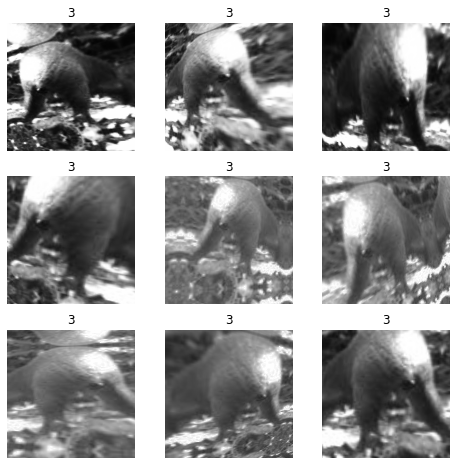

In [7]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

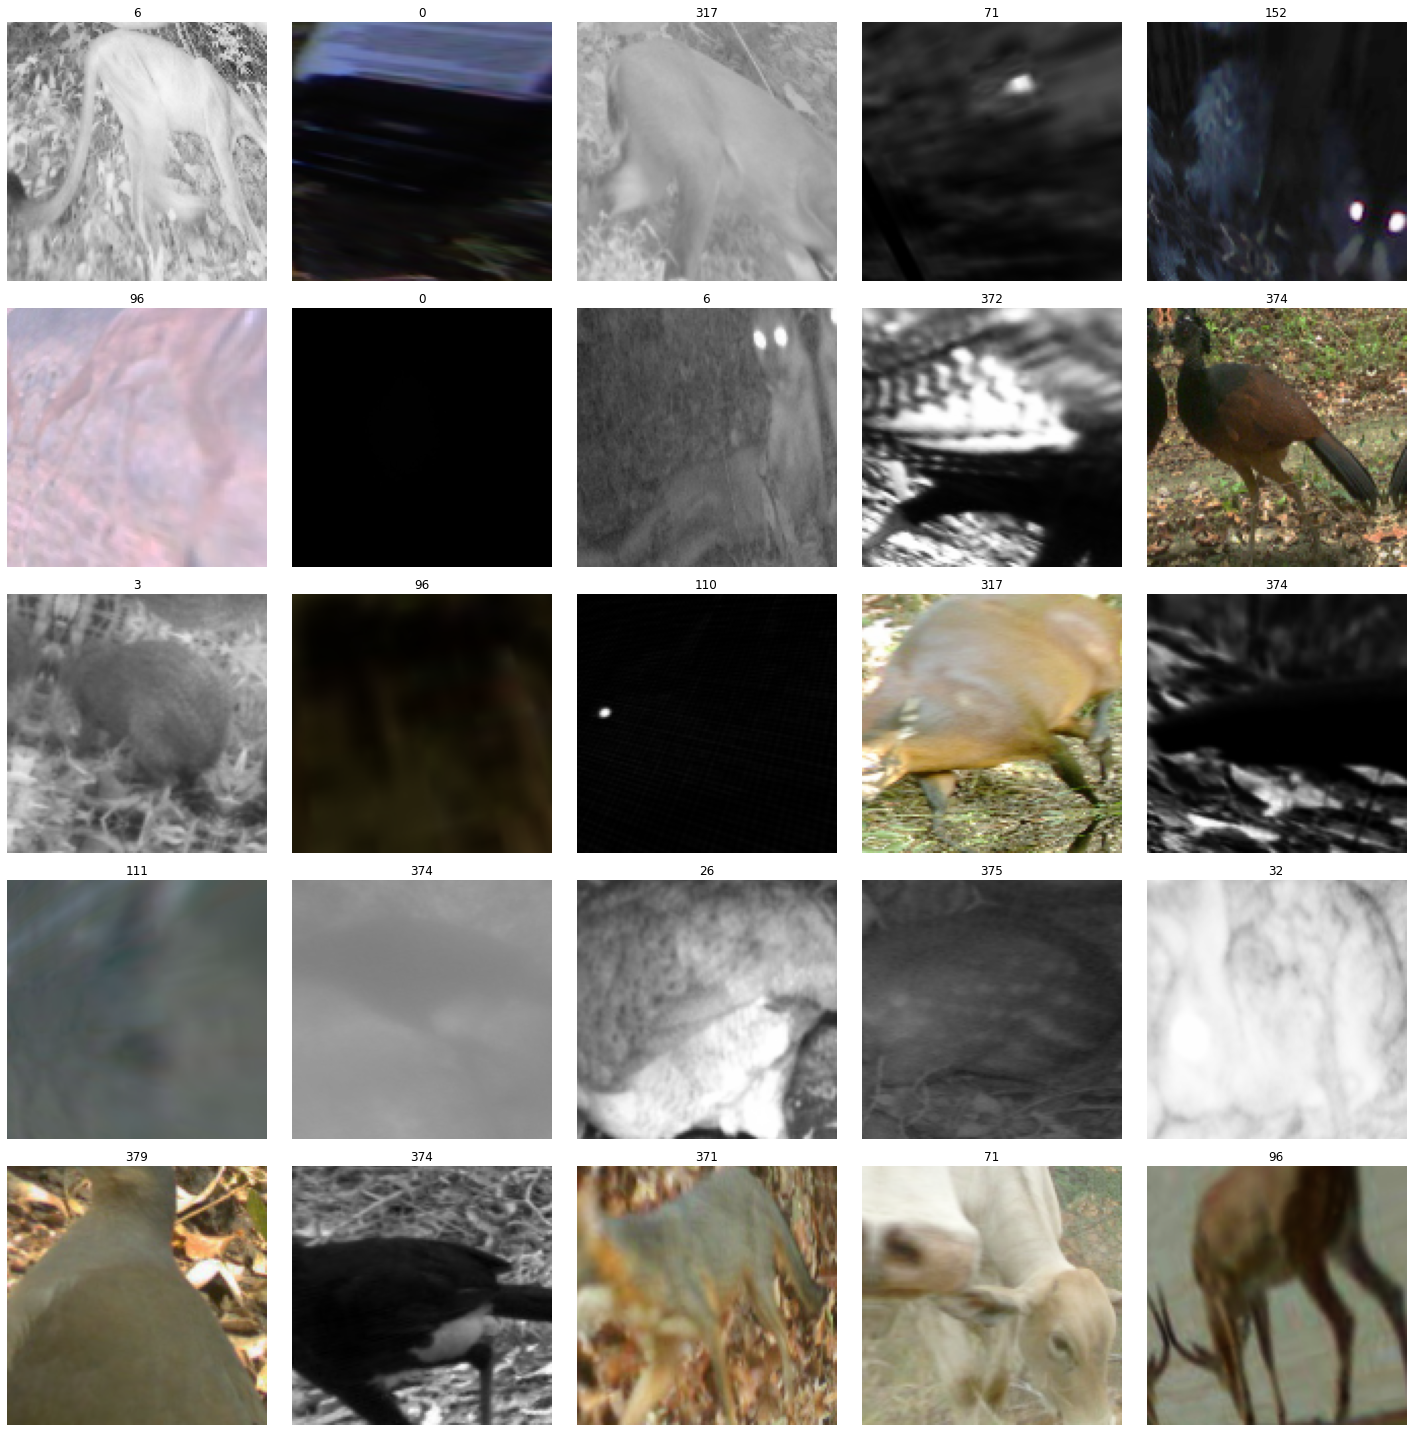

In [8]:
data.show_batch()

In [9]:
data.c

209

In [10]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 8.32E-03


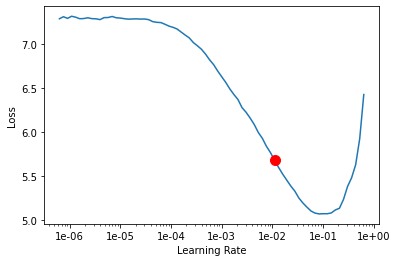

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
learn.recorder.min_grad_lr

0.01096478196143185

In [13]:
learn.fit_one_cycle(1, slice(0.003))

epoch,train_loss,valid_loss,accuracy,time
0,1.321777,0.918811,0.756251,11:54


In [14]:
learn.fit_one_cycle(10, slice(0.003))

epoch,train_loss,valid_loss,accuracy,time
0,1.224185,0.845899,0.775388,10:04
1,1.187483,0.819517,0.780990,09:37
2,1.107554,0.744259,0.799526,09:56
3,1.003538,0.682046,0.814265,10:00
4,0.921145,0.623327,0.828966,10:12
5,0.858662,0.584315,0.841561,10:10
6,0.797495,0.550285,0.850697,10:19
7,0.767025,0.527620,0.857315,09:58
8,0.751683,0.515150,0.859420,09:46
9,0.739799,0.514468,0.860097,09:52


In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(6, max_lr = slice(1e-5/2, 0.0005))

epoch,train_loss,valid_loss,accuracy,time
0,0.743909,0.506843,0.861187,10:34
1,0.688082,0.486143,0.866677,10:31
2,0.607159,0.435037,0.879686,10:36
3,0.532531,0.392285,0.889837,10:42
4,0.466693,0.364756,0.898146,10:36
5,0.432813,0.359709,0.898861,10:15


In [17]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [18]:
y

tensor([0, 0, 0,  ..., 0, 0, 0])

In [20]:
pred_csv = pd.DataFrame(preds.numpy())

In [21]:
pred_csv.to_csv("outout_preds.csv",index = False)

In [22]:
img_ids = pd.DataFrame({'Id': learn.data.test_ds.items})
img_ids.to_csv("img_ids.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [23]:
## __TODO__ fix wrong pred labels
# submission = pd.read_csv('../input/iwildcam2020-animal-crops/test_set.csv')
# id_list = list(submission.file_name)
# pred_list = list(np.argmax(preds.numpy(), axis=1))
# pred_dict = dict((key, value.item()) for (key, value) in zip(learn.data.test_ds.items,pred_list))
# pred_ordered = [pred_dict['../input/iwildcam2020-animal-crops/animal_crops_test/' + id] for id in id_list]
# submissions = pd.DataFrame({'Id':id_list,'Category':pred_ordered})
# submissions.to_csv("submission.csv".format(Category),index = False)